In [2]:
# # this code is for an elaine problem:
# import sys
# sys.path.append('/Users/elainecunha/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages')

In [12]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data, run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA
from config import *

### Define LUNA Hyperparameters

### Generate Cubic Dataset

Generates 100 datapoints for train and 100 points for test according to the function

$$y = \frac{1}{2}x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

In [13]:
# list to track runtimes
times = []

# list of difference to test:
diffs = [0.1, 0.001, 0.0001]

# set max_iteration to 3500
opt_params['max_iteration'] = real_max_iteration

# initialize train and validation data
x_train, y_train, x_test = generate_data(training_seed)
x_valid, y_valid, _ = generate_data(valid_seed)

In [14]:
#JACK
# Edit grad_func_specs dictionary for fixed step sizes

grad_func_specs_1 = {'fixed' : 0.1}
grad_func_specs_001 = {'fixed' : 0.001}
grad_func_specs_0001 = {'fixed' : 0.0001}

### Train LUNA

`luna_1` uses a column of fixed step size = 0.1

`luna_001` uses a column of fixed step size = 0.001

`luna_0001` uses a column of fixed step size = 0.0001

In [15]:
t0 = time.time()
luna_1 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_1)
luna_1.train(x_train, y_train, opt_params)
times.append(np.round(time.time() - t0, 3))
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 3400 lower bound -5834.891116060669; gradient mag: 103.954646773123664
Done Training
time: 3751.601 seconds


In [16]:
t0 = time.time()
luna_001 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_001)
luna_001.train(x_train, y_train, opt_params)
times.append(np.round(time.time() - t0, 3))
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 3400 lower bound -5021.286982443893; gradient mag: 8061.89784125883744
Done Training
time: 3535.841 seconds


In [17]:
t0 = time.time()
luna_0001 = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, luna_architecture, 
            random_seed, grad_func_specs= grad_func_specs_0001)
luna_0001.train(x_train, y_train, opt_params)
times.append(np.round(time.time() - t0, 3))
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 3400 lower bound -4773.6031041755305; gradient mag: 257.40847328731275
Done Training
time: 3515.138 seconds


In [18]:
LL_scalar_delta = []
for model in [luna_1, luna_001, luna_0001]:
    LL_scalar_delta.append(model.get_log_l(x_train,y_train,x_valid,y_valid))

In [19]:
print('log-likelihood for Scalar Step:\n')
print(f'log-likelihood for size = 0.1:    {LL_scalar_delta[0]}')
print(f'log-likelihood for size = 0.001:  {LL_scalar_delta[1]}')
print(f'log-likelihood for size = 0.0001: {LL_scalar_delta[2]}')

log-likelihood for Scalar Step:

log-likelihood for size = 0.1:    -130.51179802025166
log-likelihood for size = 0.001:  -130.07529831638232
log-likelihood for size = 0.0001: -140.87529857926108


### Compare Results

- Appears like they have a reduced "uncertainty" where we should see more.  In other words, the random step size helps to give more predictive uncertainty

- Calculate MSE as a quantative metric?

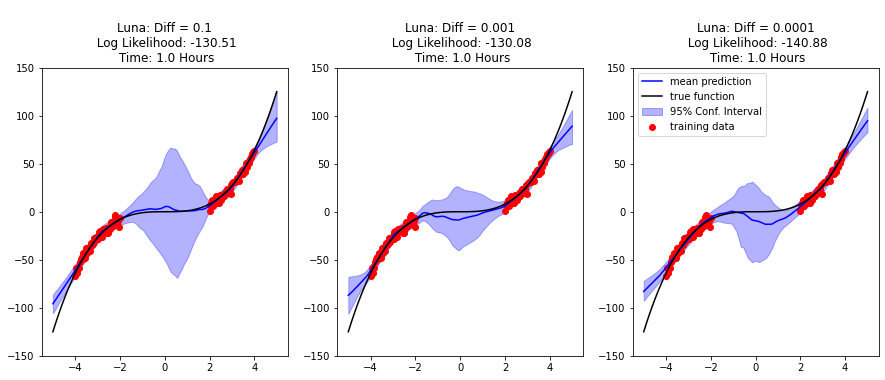

In [20]:
fig,ax = plt.subplots(1,3 ,figsize=(15,5.3))
i = 0
for model in [luna_1, luna_001, luna_0001]:
    predictives, predictive_samples = model.predict(x_test)
    log_l = model.get_log_l(x_train,y_train,x_valid,y_valid)
    name = f"\nLuna: Diff = {diffs[i]}" + f"\n Log Likelihood: {round(log_l,2)}" + f"\n Time: {round(times[i]/(60*60))} Hours"
    ax[i]=bh.viz_pp_samples(x_train, y_train,x_test.flatten(),predictive_samples,name, ax[i])
    
    i +=1
plt.legend()
fig.savefig(f"figs/LUNA_fixed_finite_diff_{str(opt_params['max_iteration'])}_iterations.png")